### Fine-tuning of a sentiment analysis classification model ###
Use AutoConfig to add the labels

In [10]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
from pprint import pprint
import textwrap
from pathlib import Path
from pprint import pprint
from matplotlib import pyplot as plt

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# PyTorch
import torch
from torchinfo import summary

# Hugging Face 
from transformers import pipeline, set_seed, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoConfig

# This HuggingFace community-driven open-source library of datasets
from datasets import load_dataset, load_metric

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import transformermodels as tm
print(f'Package version: {tm.__version__}')
print(f'PyTorch version: {torch.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Package version: 0.0.post1.dev8+gd983d5a.d20240721
PyTorch version: 2.3.1+cu121


In [3]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce GTX 1080 with Max-Q Design
CUDNN version:         8902

Device for model training/inference: cuda:0


In [4]:
# Helper functions and parameters
def wrap(x):
    return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

# Directories
data_dir = os.path.join(os.environ.get('HOME'), 'data', 'transformers')
model_dir = os.path.join(data_dir, 'model_trained')
Path(model_dir).mkdir(parents=True, exist_ok=True)
# Load the HuggingFace datasets
# Full list of datasets
# https://huggingface.co/datasets
# dataset = load_dataset('amazon_polarity')

# The custom data set
#!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv
data_file_name = 'AirlineTweets.csv'
data_file = os.path.join(data_dir, data_file_name)
df_ = pd.read_csv(data_file)
display(df_.head(2))

# We only need the text and the labels
df = df_[['text', 'airline_sentiment']]
display(df.head())

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


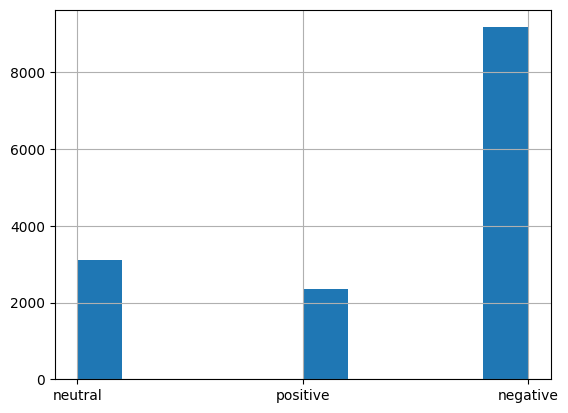

In [5]:
df['airline_sentiment'].hist()
plt.show()
# This is a highly imbalanced data set

In [6]:
# Map the labelsto integers
print(list(df['airline_sentiment'].unique()))
# Hard-code the label mapping
label_names = ['negative', 'positive', 'neutral']
label_targets = [0, 1, 2]
label_dict = dict(zip(label_names, label_targets))
pprint(label_dict)

# This is cool: we do not use apply here. Just mappings.
df = df_[['text', 'airline_sentiment']].assign(target=df_['airline_sentiment'].map(label_dict))
display(df.head())

['neutral', 'positive', 'negative']
{'negative': 0, 'neutral': 2, 'positive': 1}


,text,airline_sentiment,target
0,@VirginAmerica What @dhepburn said.,neutral,2
1,@VirginAmerica plus you've added commercials t...,positive,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0


In [7]:
# Create a simplified df
df2 = df[['text', 'target']]

# To use the "load_dataset" function, we need to have specific column names
df2.columns = ['sentence', 'label']
display(df2.head())

df2_name = f'{os.path.splitext(data_file_name)[0]}.parquet'
df2_file = os.path.join(data_dir, df2_name)
print(df2_file)
df2.to_parquet(df2_file)

,sentence,label
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


/home/andreas/data/transformers/AirlineTweets.parquet


In [8]:
# Load the .parquet file as a HuggingFace dataset
raw_dataset = load_dataset('parquet', data_files=df2_file)
split = raw_dataset.get('train').train_test_split(test_size=0.3, seed=42)

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
display(split)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [12]:
# DEFINE MODEL CHECKPOINT
checkpoint = 'distilbert-base-cased'

# CONFIG
config = AutoConfig.from_pretrained(checkpoint)
display(config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.42.4",
  "vocab_size": 28996
}

In [20]:
pprint(dir(config))

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attn_implementation',
 '_attn_implementation_internal',
 '_auto_class',
 '_commit_hash',
 '_create_repo',
 '_dict_from_json_file',
 '_get_config_dict',
 '_get_files_timestamps',
 '_get_generation_defaults',
 '_has_non_default_generation_parameters',
 '_name_or_path',
 '_set_token_in_kwargs',
 '_upload_modified_files',
 'activation',
 'add_cross_attention',
 'architectures',
 'attention_dropout',
 'attribute_map',
 'bad_words_ids',
 'begin_suppress_tokens',
 'bos_token_id',
 'chunk_size_feed_forward',
 'cross_attention_hidden_size',
 'decoder_start_token_id',
 'dict_torch_dtype_to_str

In [27]:
label_dict = dict(zip(label_names, label_targets))
print(label_dict)
label_dict_inv = {v: k for k, v in label_dict.items()}
print(label_dict_inv)
print()

{'negative': 0, 'positive': 1, 'neutral': 2}
{0: 'negative', 1: 'positive', 2: 'neutral'}



In [34]:
# We will replace the label names with the correct information
config.id2label = label_dict_inv
config.label2id = label_dict

print(config.id2label)
print(config.label2id)

{0: 'negative', 1: 'positive', 2: 'neutral'}
{'negative': 0, 'positive': 1, 'neutral': 2}


In [36]:
# DEFINE THE MODEL
model = AutoModelForSequenceClassification.\
                from_pretrained(pretrained_model_name_or_path=checkpoint, config=config)
# CREATE TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
def tokenize_fn(batch):
    ''' We need to handle truncation here. Padding will be handled by the Trainer class '''
    return tokenizer(batch.get('sentence'), truncation=True)

# TOKENIZE THE DATA SETS
tokenized_datasets = split.map(tokenize_fn, batched=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [38]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [41]:
# METRICS FUNCTION
def compute_metrics(logits_and_labels):
    """ We need this for the trainer to compute the evaluation metrics """
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    output_dict = {'acc': acc, 'f1': f1}
    return output_dict

In [42]:
# TRAINING ARGUMENTS
output_dir = os.path.join(model_dir, 'custom_sentiment_autoconfig')
Path(output_dir).mkdir(exist_ok=True, parents=True)
training_args = TrainingArguments(output_dir=output_dir,
                                  eval_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  logging_steps=50,
                                  per_device_train_batch_size=96,
                                  per_device_eval_batch_size=96)

In [44]:
# TRAINER CLASS
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tokenized_datasets.get('train'),
                  eval_dataset=tokenized_datasets.get('test'),
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [45]:
# Train the model
trainer.train()
# Save the final model
trainer.save_model(output_dir)

Epoch,Training Loss,Validation Loss,Acc,F1
1,0.476300,0.440981,0.820811,0.759985
2,0.336300,0.442912,0.833561,0.771935
3,0.247200,0.453683,0.836749,0.786102


In [46]:
# Load the model from the training checkpoint
custom_checkpoint = os.path.join(output_dir, 'checkpoint-214')
print(custom_checkpoint)

/home/andreas/data/transformers/model_trained/custom_sentiment_autoconfig/checkpoint-214


In [47]:
savedmodel = pipeline(task='text-classification', model=custom_checkpoint, device=device)

In [48]:
print(savedmodel('I love the movies on this airline.'))

[{'label': 'positive', 'score': 0.8119626045227051}]
